# Testing Square vs Round Hitboxes

Many years ago, Mark_GGG suggested that hitboxes are square in PoE
(i.e. radii of game entities are computed using Manhattan distance
instead of using Euclidean distance). This notebook has two purposes:

 1. estimate how much of a difference square versus round hitboxes
    make, and
    
 1. have hit rate numbers to compare against empirical tests.
 
Note: I didn't feel like doing a bunch of calculus this weekend, so these
analyses are done in a brute force way by creating various stencils
and using a mathematical trick called convolution. If PoE uses
discrete locations, then this is actually the correct thing to do,
assuming we can model exactly how they do all the rounding (a rather
tricky thing). If PoE uses continuous locations, then all of this
is just a rough approximation (and carefully using calculus is the
right approach). This notebook has a `super_sample_factor` that we
can use to smoothly shift between the two.  A bigger factor means
we do a better job approximating continuous positions, but runtime
goes up as the square of this factor.

# Notebook Config

Here we import the various packages that we use, and here we reconfigure
Jupyter notebook to make it friendlier.

All of these are easy to install with `pip` or the Anaconda distribution of
Python.

In [1]:
from __future__ import print_function

# Make plots work.
%matplotlib inline

# We have some wide tables.  Stop Jupyter from using an artificially
# narrow fixed-with column in the web browser.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import some useful stuff
# This MUST come after the %matplotlib inline magic.
import pandas as pd
import numpy as np
import pylab
import textwrap
from cStringIO import StringIO
from scipy.signal import fftconvolve
from scipy.ndimage.interpolation import shift

# Monkey patch qgrid for rendering data frames as sortable.
# It's not great, but it's better than pandas' default renderer.
try:
    import qgrid
except Exception:
    print('Cannot import qgrid, skipping monkey patch')
else:
    qgrid.nbinstall(overwrite=True)
    def _repr_qgrid_(df):
        qgrid.show_grid(df)
        return None
    pd.DataFrame._repr_html_ = _repr_qgrid_
    
def draw(r, g=None, b=None, norm=True):
    if g is None: g = r
    if b is None: b = g
    assert len(x) == len(y)
    rgb = np.asarray([r, g, b], dtype='float').T
    if norm:
        rgb /= rgb.max()
    pylab.imshow(rgb)
    pylab.xticks(np.arange(0, len(x), super_sample_factor * 10),
                 np.round(x[::super_sample_factor*10]).astype('int'))
    pylab.yticks(np.arange(0, len(x), super_sample_factor * 10),
                 np.round(y[::super_sample_factor*10]).astype('int'))

# Assumptions and Fixed Inputs

In [2]:
# Radius Assumptions
#
# Source: http://pathofexile.gamepedia.com/Molten_Strike
# Source: https://redd.it/568ew3

inner_rad   =   5 # NOT affected by AoE: https://www.pathofexile.com/forum/view-thread/916639/page/2#p7790589
outer_rad   =  20 # affected by all aoe area modifiers
arc_degrees = 270 # not affected by anything

ball_rad = 9  # radius of a molten strike ball's hitbox
boss_rad = 2  # presumed radius of a boss' hitbox (3 for bosses, 2 for normal humanoids, 1 for little stuff); might actually be 5 for some bosses

# Radius Stencils

Here we create two types of radius stencils that we'll use for the
convolutions. L^2 uses normal circular radii, i.e. radius = sqrt(x^2 + y^2).
L^1 uses squares computed using the Manhattan distance, i.e.
radius = abs(x) + abs(y).  L^2 is much easier to think about, but Mark_GGG
has stated that game entities use L^1 distances.

In [82]:
# The super sample factor tells how many little squares we'll
# use per PoE distance unit.  Larger factors are more accurate
# but they consume a lot more memory and slow down some of the
# computations (especially the convolution).
super_sample_factor = 1
window_radius       = outer_rad * 1.25 # add some padding

if super_sample_factor > 64:
    raise ValueError('You are likely to blow up your memory with '
                     'such a high super sample factor.')

dx     = 1.0/super_sample_factor
x      = np.asarray(np.arange(-window_radius, window_radius+dx, dx), dtype='float64')
y      = np.asarray(np.arange(-window_radius, window_radius+dx, dx), dtype='float64')
xx, yy = np.broadcast_arrays(x[:, None], y[None, :]) # transposed to make displaying easier
rr     = {
    'l1_00deg': np.abs(xx) + np.abs(yy),  # L1 distance (contours look like a diamond)
    'l1_45deg': np.maximum(np.abs(xx), np.abs(yy)) * np.sqrt(2), # hack to compute the rotated L1 using Linf
    'l2':       np.sqrt(xx**2 + yy**2),              # L2 distance (contours look like a circle)
}
pylab.figure(figsize=(9,3))
pylab.subplot(131); draw(rr['l1_00deg']); pylab.title('$L^1$')
pylab.subplot(132); draw(rr['l1_45deg']); pylab.title('$L^1$ (rotated 45 degrees)')
pylab.subplot(133); draw(rr['l2']); pylab.title('$L^2$')

# Weighted Ball Landing Stencil

Here we compute the stencils that represent the chance of a ball
to hit any particular location given that the melee hit location
is at xx=0 and yy=0 and the attack is angled directly on the
positive x-axis.

In [83]:
r = rr['l2'] # Just playing MS, it's obvious this needs to be L^2.
ms_ball_coverage = (
    (r[:, :] >= inner_rad) &
    (r[:, :] <= outer_rad) &
    (np.abs(np.arctan2(yy, xx) * 360 / (2 * np.pi)) < arc_degrees / 2)
)
# This is the probability of a ball hitting a particular point within
# the stencil.  See https://redd.it/568ew3 for details.
ms_ball_hit_frac = (
    ms_ball_coverage /
    # np.maximum is to deal with a blowup at the origin.  The correct
    # way is to realize that we should be integrating over our sample
    # pixels rather than taking point samples, but that's more work
    # and the approximation error inside the hit mask is tiny since
    # it has a min radius of 5 units.
    np.maximum(1e-9, r)
)
ms_ball_hit_frac /= ms_ball_hit_frac.sum(axis=1).sum(axis=0) # normalize it to a probability distribution
del r # make sure we don't accidentally use the wrong one in other cells
draw(ms_ball_hit_frac, norm=True)
pylab.title('probability of a ball landing at a pixel')

# Boss Hitbox Stencils

L^1 and L^2 stencils that encode the hitbox for a boss.

Note that the stencil areas for the two L^1 cases are not equal. This is due to
quantization effects. This author doesn't know if PoE operates in a floating point
versus discrete world. A lot of statements by Mark_GGG suggest it's discrete, and
if so, then these quantization errors might be real.

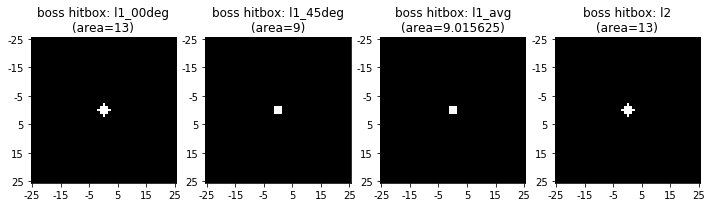

In [84]:
def get_and_show_hitboxes(box_rad):
    hitboxes = {
        k: rr[k] <= box_rad
        for k in rr.keys()
    }

    hitboxes['l1_avg'] = (
        np.mean(
            [
                np.abs(xx * np.cos(radians) - yy * np.sin(radians)) +
                np.abs(xx * np.sin(radians) + yy * np.cos(radians)) <= box_rad
                for radians in np.arange(0, np.pi / 2, (np.pi/2)/256)
            ],
            axis=0,
        )
    )

    pylab.figure(figsize=(12,3))
    for i, k in enumerate(sorted(hitboxes.keys())):
        pylab.subplot(1, 4, i + 1)
        draw(hitboxes[k])
        pylab.title('boss hitbox: {}\n(area={})'.format(k, hitboxes[k].sum()))

    return hitboxes

boss_hitboxes = get_and_show_hitboxes(boss_rad)

# Ball Stencils

Same idea as the box hitbox stencils.

In [85]:
ball_hitboxes = get_and_show_hitboxes(ball_rad)

# Estimating Hit Chance

Here we convolve everything to estimate the hit chances under
all combination of assumptions about how ball and boss hitboxes
work.

In [86]:
num_rots = 32
assert len(ball_hitboxes) == 4
assert len(boss_hitboxes) == 4
print(' '*20 + 'boss hitbox type')
print(' '*8, end=' '); print(' '.join('{:8s} '.format(k) for k in sorted(boss_hitboxes)))
pylab.figure(figsize=(12,12))
for i, k_ball in enumerate(sorted(ball_hitboxes)):
    print('{:8s}'.format(k_ball), end=' ')
    if k_ball == 'l1_avg':
        ball_stencils = [
            np.abs(xx * np.cos(radians) - yy * np.sin(radians)) +
            np.abs(xx * np.sin(radians) + yy * np.cos(radians)) <= ball_rad
            for radians in np.arange(0, np.pi / 2, (np.pi/2)/num_rots)
        ]
    else:
        ball_stencils = [ball_hitboxes[k_ball]]
    
    for j, k_boss in enumerate(sorted(boss_hitboxes)):
        if k_boss == 'l1_avg':
            boss_stencils = [
                np.abs(xx * np.cos(radians) - yy * np.sin(radians)) +
                np.abs(xx * np.sin(radians) + yy * np.cos(radians)) <= boss_rad
                for radians in np.arange(0, np.pi / 2, (np.pi/2)/num_rots)
            ]
        else:
            assert np.all((boss_hitboxes[k_boss] == 0) |
                          (boss_hitboxes[k_boss] == 1))
            boss_stencils = [boss_hitboxes[k_boss]]
            
        # Estimate the probability of a ball and boss being close enough
        # and in a fortutuitious enough angle to connect and get a hit.
        # All hits deal full damage, so we discretize.
        #
        # This is Prob[hits boss | ball lands at location]
        n = 0
        res = np.zeros_like(ms_ball_hit_frac, dtype='int32')
        for ball_stencil in ball_stencils:
            assert np.all((ball_stencil == 0) | (ball_stencil == 1))
            for boss_stencil in boss_stencils:
                assert np.all((boss_stencil == 0) | (boss_stencil == 1))
                res += fftconvolve(np.asarray(ball_stencil, dtype='float32'),
                                   np.asarray(boss_stencil, dtype='float32'),
                                   mode='same') > 0.5
                n += 1
        boss_and_ball = res / n
        pylab.subplot(4, 4, 1 + i * 4 + j)
        draw(boss_and_ball)
        
        # Now we can do a simple merger of that with the ball landing
        # location PMF.
        #
        # Prob[hits boss] = Sum[ Prob[hits boss | ball lands at location] *
        #                        P[ball lands at location] ]
        agg_pmf = boss_and_ball * ms_ball_hit_frac
        print('{:8.3f}'.format(agg_pmf.sum()), end=' ')
    print()

                    boss hitbox type
         l1_00deg  l1_45deg  l1_avg    l2       
l1_00deg    0.290    0.286    0.286    0.290 
l1_45deg    0.302    0.240    0.240    0.302 
l1_avg      0.230    0.193    0.193    0.230 
l2          0.392    0.364    0.364    0.392 
